In [1]:
import pandas as pd
def process_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = {}
    current_signal_id = None
    for line in lines:
        if line.startswith('#,'):
            current_signal_id = line.strip().split(',')[1]
            if current_signal_id not in data:
                data[current_signal_id] = []
        else:
            volume = line.strip()
            data[current_signal_id].append(volume)

    data = [[signal_id, ' '.join(volumes)] for signal_id, volumes in data.items()]
    df = pd.DataFrame(data, columns=['signal_id', 'volume'])
    return df



In [2]:
df = process_file(r"C:\Users\Trisss\Desktop\Capstone\Caps project\demo_upload\data\20170625")
df

,signal_id,volume
0,1498255288,"9627,1 9638,3 9650,6 9661,8 9671,10 9682,13 96..."
1,1498344071,"7907,3 7917,5 7928,5 7940,5 7951,5 7961,6 7972..."


In [3]:
def weighted_moving_average(data, timestamps, window_size):
    weights = np.arange(1, window_size + 1)
    smoothed_data = np.convolve(data, weights, 'valid') / np.sum(weights)
    smoothed_timestamps = timestamps[window_size - 1:]
    return smoothed_data, smoothed_timestamps

In [4]:
def enforce_monotonicity(values):
    corrected_values = [values[0]]
    for value in values[1:]:
        corrected_value = max(value, corrected_values[-1])
        corrected_values.append(corrected_value)
    return corrected_values

In [5]:
def input_to_df(content, index, col_name, df):
    df.loc[index, col_name] = content
    return df

In [6]:
def connect_string(a,b):
    pairs = zip(a, b)
    result = ' '.join([f'{t},{v}' for t, v in pairs])
    return result

In [137]:
def adjust_timestamps(data_str, window_size):
    data_list = data_str.split()

    timestamps = [float(pair.split(',')[0]) for pair in data_list]
    values = [float(pair.split(',')[1]) for pair in data_list]

    timestamps = pd.to_datetime(timestamps, unit='ms')
    average_distance = np.mean(np.diff(timestamps).astype('timedelta64[ms]'))
    adjusted_timestamps = timestamps[0] + pd.to_timedelta(np.arange(len(timestamps)) * average_distance)

    time = (adjusted_timestamps - adjusted_timestamps[0]).total_seconds() * 1000
    time = time.astype(int).tolist()

    smoothed_values, smoothed_timestamps = weighted_moving_average(values, time, window_size)
    pos_val = enforce_monotonicity(smoothed_values)
    sv, st = weighted_moving_average(pos_val, smoothed_timestamps, window_size)

    sv = sv/10
    sv = [round(val, 2) for val in sv]
    
    st = np.array(st)/1000
    st = st - min(st)
    st = [round(val, 4) for val in st]
    result = connect_string(st, sv)
    return result, st, sv

In [138]:
def flow_rate_gen(smoothed_timestamps, sc_values):

    volume_diff = np.array(sc_values[50:]) - np.array(sc_values[:-50])
    time_diff_seconds = np.array(smoothed_timestamps[50:]) - np.array(smoothed_timestamps[:-50])

    flow_rate_per_second = volume_diff / time_diff_seconds
    sm_time = smoothed_timestamps[50:]
    st =  sm_time - min(sm_time)
    st = [round(val, 4) for val in st]
    fr = [round(val, 2) for val in flow_rate_per_second]

    result = connect_string(st, fr)

    return result, st, fr

In [139]:
df = process_file(r"C:\Users\Trisss\Desktop\Capstone\Caps project\demo_upload\data\20170625")
df

,signal_id,volume
0,1498255288,"9627,1 9638,3 9650,6 9661,8 9671,10 9682,13 96..."
1,1498344071,"7907,3 7917,5 7928,5 7940,5 7951,5 7961,6 7972..."


In [140]:
df = process_file(r"C:\Users\Trisss\Desktop\Capstone\Caps project\demo_upload\data\20170625")
df
import numpy as np
window_size = 50
for i in df.index:
    volume_string, time, volume = adjust_timestamps(df.loc[i, 'volume'], window_size)
    flow_rate_string, fr_time, flow_rate = flow_rate_gen(time, volume)
    median_volume = np.median(volume)
    max_flowrate = np.max(flow_rate)

    step = fr_time[1] - fr_time[0]
    voided_volume_per_interval = np.sum(flow_rate)
    voided_volume = voided_volume_per_interval*step

    average_flow_rate = voided_volume / max(fr_time)
    time_to_max_flow_rate = time[np.argmax(flow_rate)] - time[0]
    flow_time = max(time)

    df.loc[i, ["volume", "flow", "median_volume", "voided_volume", "max_flow_rate", "avg_flow_rate", "time_to_max_flow_rate", "flow_time"]] = [volume_string, flow_rate_string, median_volume, voided_volume, max_flowrate, average_flow_rate, time_to_max_flow_rate, flow_time]

In [141]:
df

,signal_id,volume,flow,median_volume,voided_volume,max_flow_rate,avg_flow_rate,time_to_max_flow_rate,flow_time
0,1498255288,"0.0,1.66 0.011,1.69 0.022,1.71 0.033,1.73 0.04...","0.0,6.22 0.011,6.36 0.022,6.55 0.033,6.73 0.04...",200.87,197.99197,21.25,4.155915,5.368,48.191
1,1498344071,"0.0,3.0 0.011,3.08 0.022,3.16 0.033,3.23 0.044...","0.0,7.64 0.011,7.67 0.022,7.73 0.033,7.78 0.04...",188.68,186.97580,16.38,1.878002,5.577,100.111


In [125]:

print("Median Volume:", median_volume)
print("Max Flowrate:", max_flowrate)
print("Voided Volume:", voided_volume)
print("Average Flow Rate:", average_flow_rate)
print("Flow Time:", flow_time)
print("Time to Max Flow Rate:", time_to_max_flow_rate)


Median Volume: 200.87
Max Flowrate: 21.254545454545458
Voided Volume: 197.9877324163077
Average Flow Rate: 4.155826544705352
Flow Time: 48.190999999999995
Time to Max Flow Rate: 5.412


In [48]:
df["signal_id"]= pd.to_numeric(df["signal_id"], errors='coerce')
signal_id = df['signal_id']
for id in signal_id:
    print(id)
    df_1 = df[df['signal_id'] == id]

    # Get the 'volume' data for this row
    volume_data = df_1['volume'].values[0]

    # Split the string into a list of timestamp-value pairs
    data_list = volume_data.split()

    # Separate the timestamps and values into two lists
    timestamps = [float(pair.split(',')[0]) for pair in data_list]
    values = [float(pair.split(',')[1]) for pair in data_list]
    break


1498255288


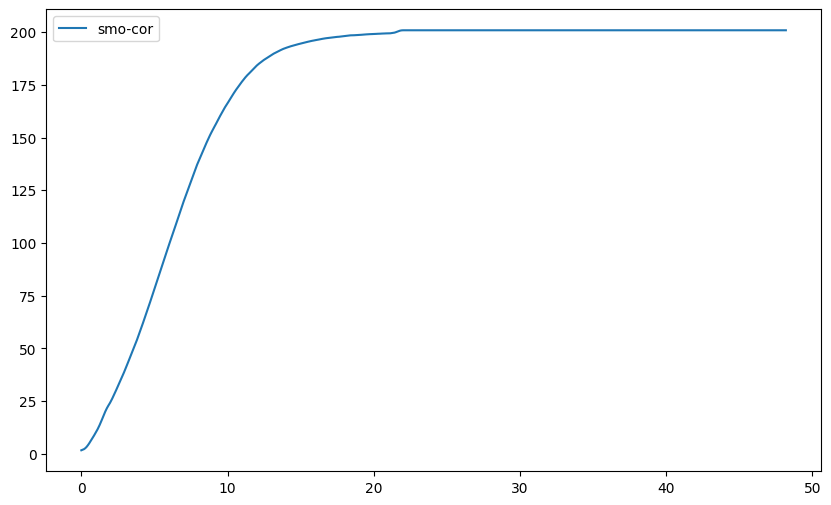

In [49]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(timestamps, values, label='smo-cor')

plt.legend()
plt.show()

In [50]:
import numpy as np

# Convert your time data from milliseconds to seconds
# smoothed_timestamps_seconds = np.array(timestamps) / 1000

# Calculate the differences between volume measurements 5 steps apart
volume_diff = np.array(values[50:]) - np.array(values[:-50])

# Calculate the differences between timestamps in seconds, 5 steps apart
time_diff_seconds = np.array(timestamps[50:]) - np.array(timestamps[:-50])

# Calculate the flow rate in ml/s
flow_rate_per_second = volume_diff / time_diff_seconds


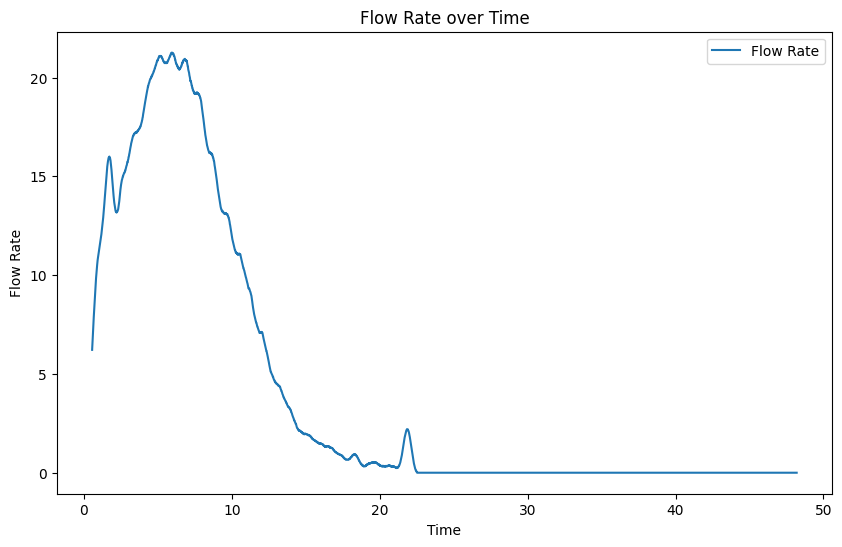

In [51]:
# Plot the flow rate over time
plt.figure(figsize=(10, 6))
plt.plot(timestamps[50:], flow_rate_per_second, label='Flow Rate')
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.title('Flow Rate over Time')
plt.legend()
plt.show()